In [1]:
#importing libraries to read the files
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from time import gmtime, strftime 
from pylab import rcParams

#importing libraries to be used in model building
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose 

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook
from itertools import product

%matplotlib inline

In [2]:
#reading the data file
og_data=pd.read_excel("data.xlsx",header=None,index=False)
#og_data.head(12)

In [3]:
#creating train and test set

data=og_data
data=data.drop(data.columns[[0,1,2,3,4,5,6,8]],axis=1)
data=data.drop([0,1])
data=data.transpose()
data=data.rename(columns=data.iloc[0])
data=data.drop(data.index[0])
data.set_index('Generic LookupKey',inplace=True)
data=data.apply(pd.to_numeric)
df=data[data.index <'2019-10-01']
test=data.drop(df.index)
#print(test)
#print(df)

In [4]:
#displaying columns of dataframe
df.columns

Index(['Segment 2Sandesh Brand 1MobileLeopardClosing Base',
       'Segment 2Sandesh Brand 1MobileLeopardLeavers',
       'Segment 2Sandesh Brand 1MobileLeopardGross Adds',
       'Segment 2Sandesh Brand 1MobilePantherClosing Base',
       'Segment 2Sandesh Brand 1MobilePantherLeavers',
       'Segment 2Sandesh Brand 1MobilePantherGross Adds',
       'Segment 2Sandesh Brand 1MobileHyenaClosing Base',
       'Segment 2Sandesh Brand 1MobileHyenaLeavers',
       'Segment 2Sandesh Brand 1MobileHyenaGross Adds',
       'Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue'],
      dtype='object')

In [5]:
#setting the start date
output = pd.DataFrame()
output['Time Period'] = pd.date_range(start='2019-10-01', periods=12, freq='MS')
#output

In [6]:
#function to check if the column is stationary or not and plot it using Dickey-fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)


In [7]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# COLUMN1

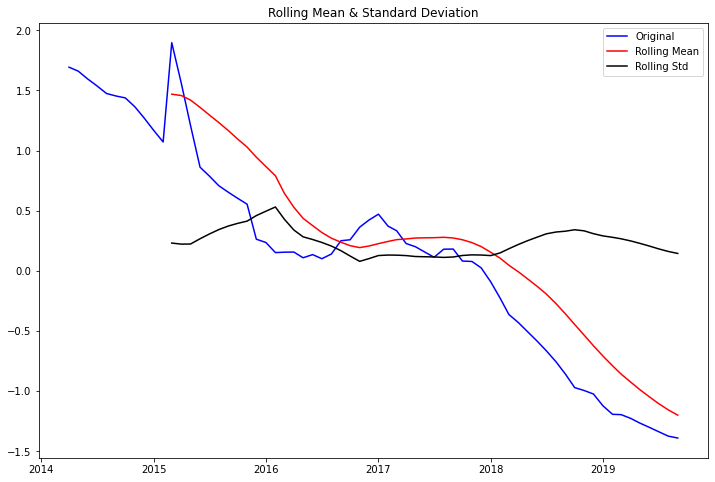

Results of Dickey-Fuller Test:
p-value = 0.8738. The series is likely non-stationary.
Test Statistic                 -0.587389
p-value                         0.873806
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [8]:
#to check whether the column is stationary or not and plotting it
test_stationarity(df['Segment 2Sandesh Brand 1MobileLeopardClosing Base'])
new1 = df['Segment 2Sandesh Brand 1MobileLeopardClosing Base']

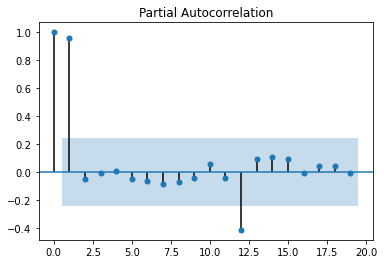

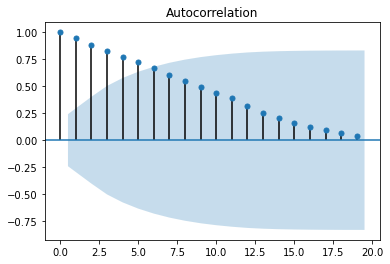

In [9]:
#plotting the pacf and acf
plot_pacf(new1);
plot_acf(new1);

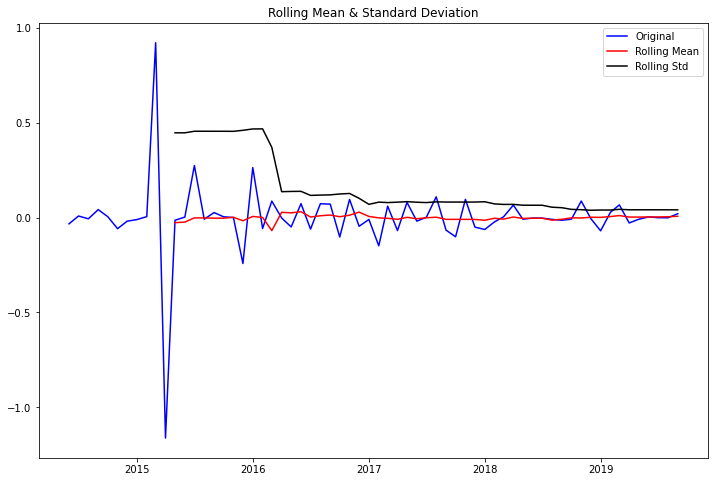

Results of Dickey-Fuller Test:
p-value = 0.0029. The series is likely stationary.
Test Statistic                 -3.802014
p-value                         0.002887
#Lags Used                      8.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [12]:
#changing the coloumn form non-stationary to stationary
first_diff_1 = df['Segment 2Sandesh Brand 1MobileLeopardClosing Base'].diff().diff()
first_diff_1 = first_diff_1.dropna(inplace = False)
test_stationarity(first_diff_1, window = 12)

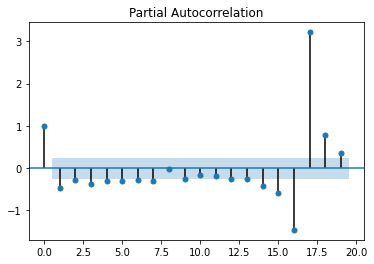

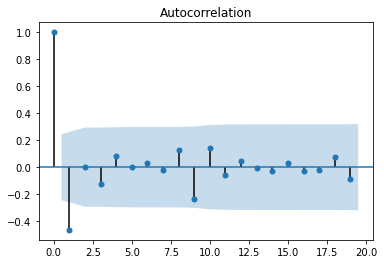

In [13]:
plot_pacf(first_diff_1);
plot_acf(first_diff_1);

In [14]:
#assiging the range of p,d,q
p = range(0, 4, 1)
d = 2
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 2
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [15]:
#getting the result of AIC and using the lowest AIC value
result_df1 = optimize_SARIMA(parameters_list, 2, 2, 4, first_diff_1)
result_df1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program

,"(p,q)x(P,Q)",AIC
0,"(0, 3, 0, 2)",22.004521
1,"(0, 3, 1, 2)",23.932117
2,"(0, 3, 0, 3)",23.972083
3,"(0, 3, 2, 1)",25.372695
4,"(0, 3, 2, 2)",25.599823
...,...,...
251,"(0, 0, 3, 0)",152.757292
252,"(0, 0, 0, 1)",157.528536
253,"(0, 0, 1, 0)",161.604017
254,"(1, 0, 0, 0)",165.884701


In [16]:
#model fitting
best_model1 = SARIMAX(first_diff_1, order=(0, 2, 3), seasonal_order=(0, 2, 2, 4)).fit(dis=-1)
print(best_model1.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                               SARIMAX Results                                               
Dep. Variable:     Segment 2Sandesh Brand 1MobileLeopardClosing Base   No. Observations:                   64
Model:                            SARIMAX(0, 2, 3)x(0, 2, [1, 2], 4)   Log Likelihood                  -5.002
Date:                                               Fri, 31 Jul 2020   AIC                             22.005
Time:                                                       22:29:31   BIC                             33.938
Sample:                                                   06-01-2014   HQIC                            26.607
                                                        - 09-01-2019                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

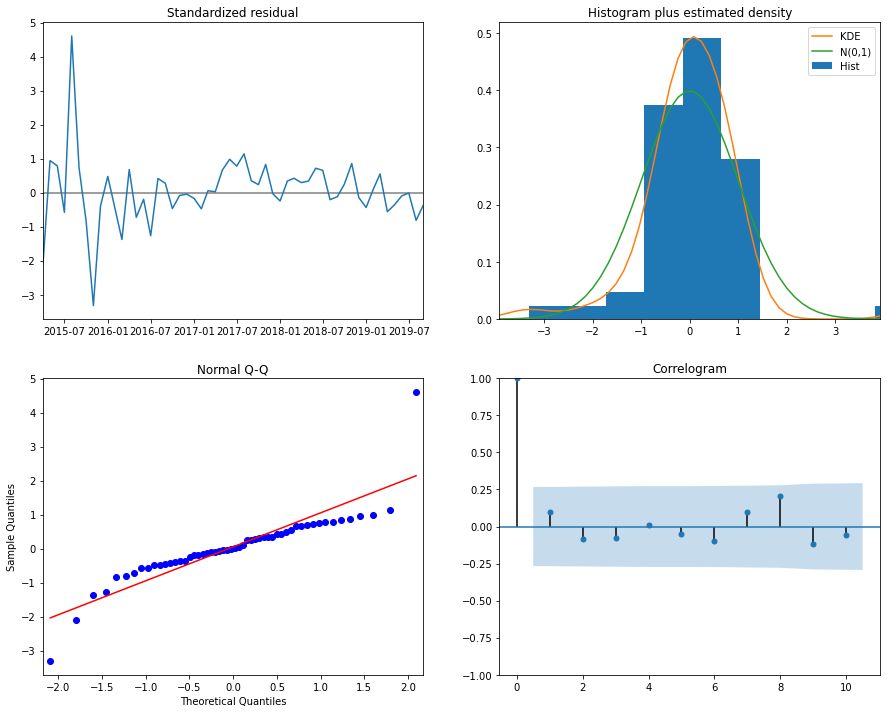

In [17]:
best_model1.plot_diagnostics(figsize=(15,12));

forecast
2020-01-01   -0.010306
2020-02-01    0.004218
2020-03-01   -0.022157
2020-04-01    0.182117
2020-05-01   -0.000945
2020-06-01    0.022556
2020-07-01   -0.019287
2020-08-01    0.221179
2020-09-01    0.012395
2020-10-01    0.044972
2020-11-01   -0.012239
2020-12-01    0.264519
2021-01-01    0.030111
Freq: MS, dtype: float64


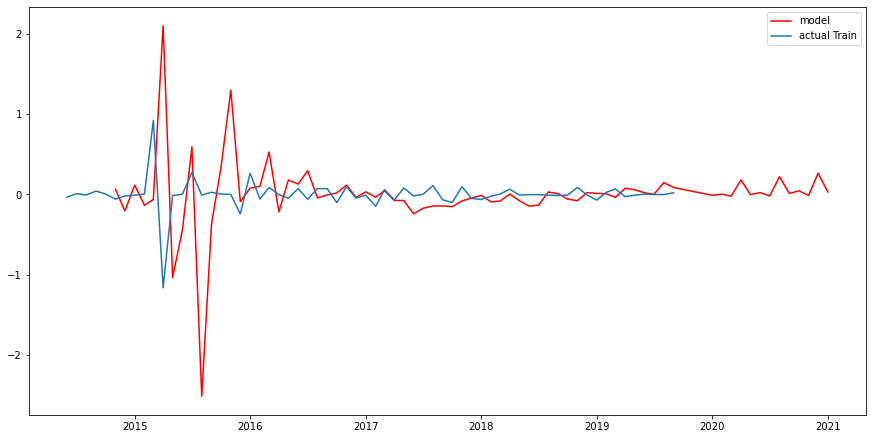

In [18]:
#plotting model vs prediction and displaying the forecast value
new1['arima_model'] = best_model1.fittedvalues
new1['arima_model'][:4+1] = np.NaN
forecast1= best_model1.predict(start=new1.shape[0], end=new1.shape[0] + 12)
x1=forecast1
print("forecast")
print(forecast1)
forecast1 = new1['arima_model'].append(forecast1)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast1, color='r', label='model')
#plt.plot(test['Segment 2Sandesh Brand 1MobileLeopardClosing Base'])
plt.plot(first_diff_1, label='actual Train')
plt.legend()
plt.show()

In [19]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileLeopardClosing Base": x1.tolist()}))

In [20]:
#displaying the output i.e forecasted value till september 2020
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base
0,2019-10-01,-0.010306
1,2019-11-01,0.004218
2,2019-12-01,-0.022157
3,2020-01-01,0.182117
4,2020-02-01,-0.000945
5,2020-03-01,0.022556
6,2020-04-01,-0.019287
7,2020-05-01,0.221179
8,2020-06-01,0.012395
9,2020-07-01,0.044972


# COLUMN2

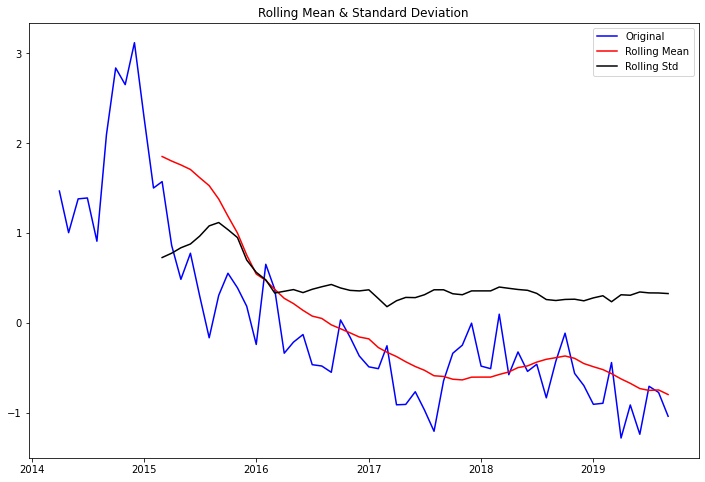

Results of Dickey-Fuller Test:
p-value = 0.5971. The series is likely non-stationary.
Test Statistic                 -1.368798
p-value                         0.597140
#Lags Used                      2.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [21]:
test_stationarity(df['Segment 2Sandesh Brand 1MobileLeopardLeavers'])
new2 = df['Segment 2Sandesh Brand 1MobileLeopardLeavers']

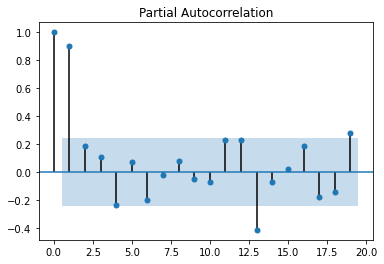

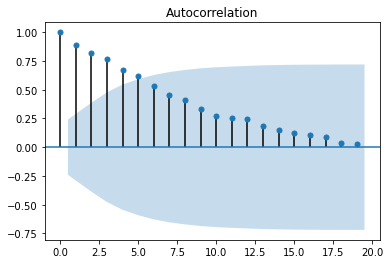

In [22]:
plot_pacf(new2);
plot_acf(new2);

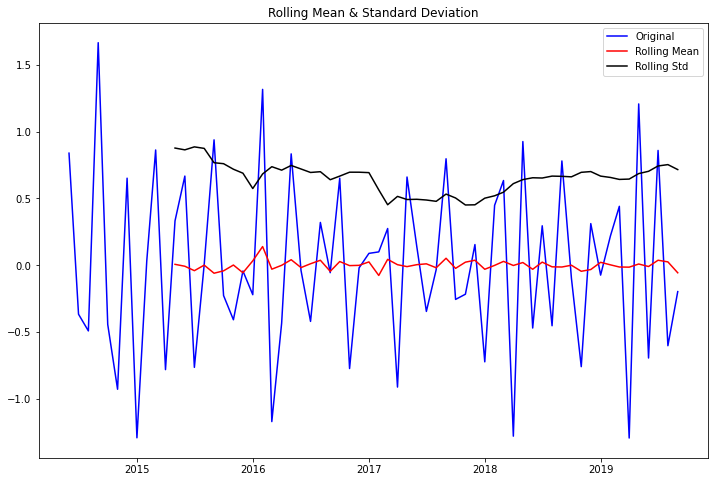

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.804272e+00
p-value                        2.196996e-09
#Lags Used                     1.000000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


In [23]:
first_diff_2 = df['Segment 2Sandesh Brand 1MobileLeopardLeavers'].diff().diff()
first_diff_2 = first_diff_2.dropna(inplace = False)
test_stationarity(first_diff_2, window = 12)

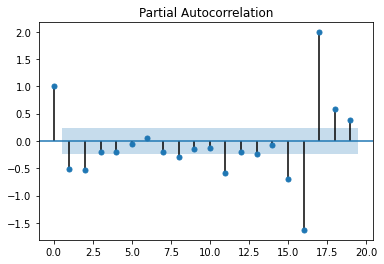

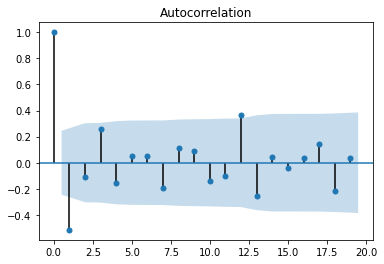

In [24]:
plot_pacf(first_diff_2);
plot_acf(first_diff_2);

In [25]:
p = range(0, 4, 1)
d = 2
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 2
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df2 = optimize_SARIMA(parameters_list, 2, 2, 4, first_diff_2)
result_df2

In [26]:
best_model2 = SARIMAX(first_diff_2, order=(2, 2, 2), seasonal_order=(2, 2, 1, 4)).fit(dis=-1)
print(best_model2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                            SARIMAX Results                                             
Dep. Variable:     Segment 2Sandesh Brand 1MobileLeopardLeavers   No. Observations:                   64
Model:                          SARIMAX(2, 2, 2)x(2, 2, [1], 4)   Log Likelihood                 -56.364
Date:                                          Fri, 31 Jul 2020   AIC                            128.729
Time:                                                  22:30:28   BIC                            144.641
Sample:                                              06-01-2014   HQIC                           134.865
                                                   - 09-01-2019                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


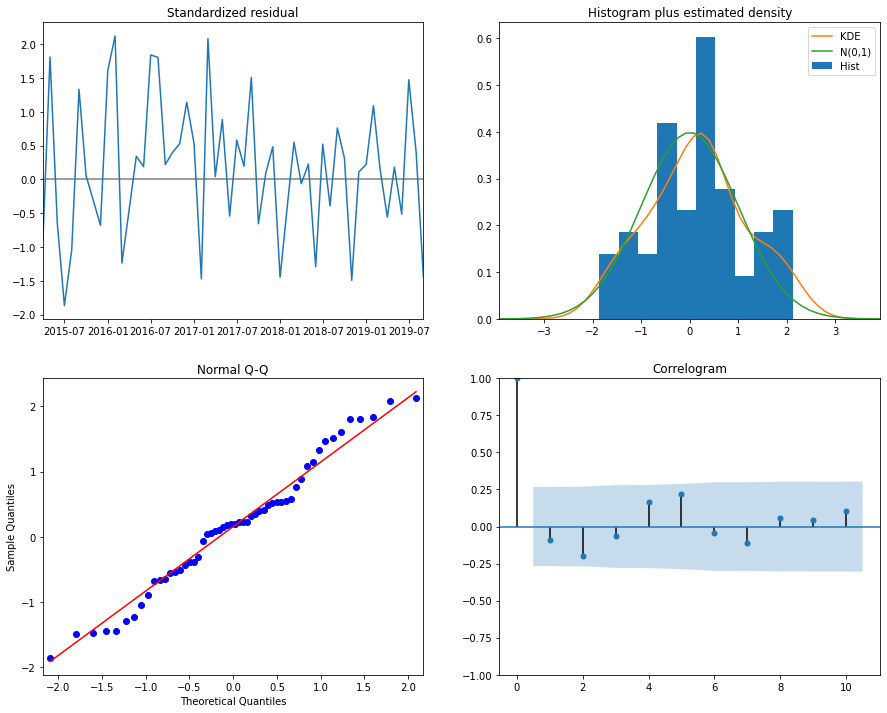

In [27]:
best_model2.plot_diagnostics(figsize=(15,12));

forecast
2020-01-01    0.616117
2020-02-01   -0.020009
2020-03-01    0.482435
2020-04-01   -1.024498
2020-05-01    0.867051
2020-06-01   -0.309297
2020-07-01    0.695308
2020-08-01   -0.714521
2020-09-01    0.187275
2020-10-01    0.470421
2020-11-01    0.091985
2020-12-01   -0.763762
2021-01-01    0.765241
Freq: MS, dtype: float64


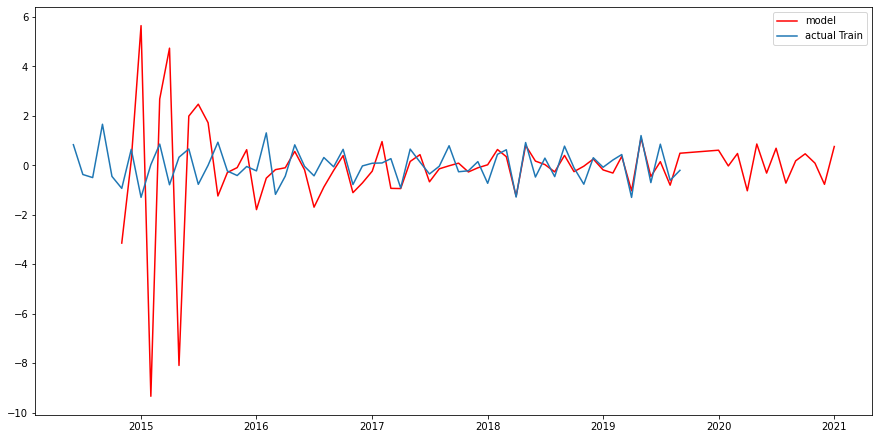

In [28]:
new2['arima_model'] = best_model2.fittedvalues
new2['arima_model'][:4+1] = np.NaN
forecast2= best_model2.predict(start=new2.shape[0], end=new2.shape[0] + 12)
x2=forecast2
print("forecast")
print(forecast2)
forecast2 = new2['arima_model'].append(forecast2)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast2, color='r', label='model')
plt.plot(first_diff_2, label='actual Train')
plt.legend()
plt.show()



In [29]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileLeopardLeavers": x2.tolist()}))

In [30]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers
0,2019-10-01,-0.010306,0.616117
1,2019-11-01,0.004218,-0.020009
2,2019-12-01,-0.022157,0.482435
3,2020-01-01,0.182117,-1.024498
4,2020-02-01,-0.000945,0.867051
5,2020-03-01,0.022556,-0.309297
6,2020-04-01,-0.019287,0.695308
7,2020-05-01,0.221179,-0.714521
8,2020-06-01,0.012395,0.187275
9,2020-07-01,0.044972,0.470421


# COLUMN 3

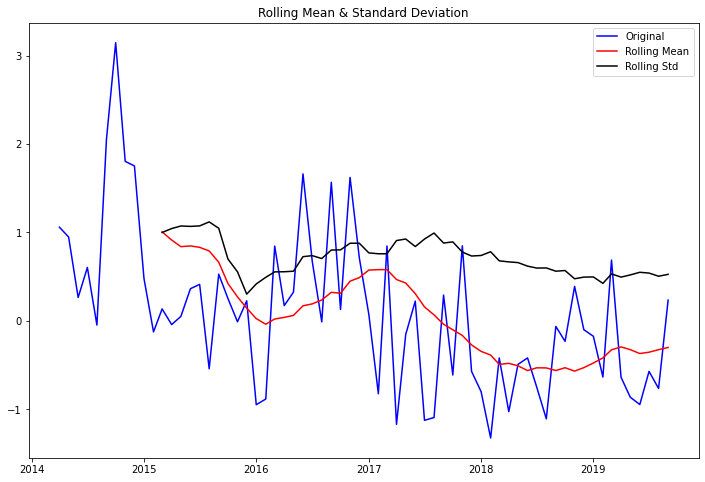

Results of Dickey-Fuller Test:
p-value = 0.0236. The series is likely non-stationary.
Test Statistic                 -3.142012
p-value                         0.023596
#Lags Used                      6.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [31]:
test_stationarity(df['Segment 2Sandesh Brand 1MobileLeopardGross Adds'])
new3 = df['Segment 2Sandesh Brand 1MobileLeopardGross Adds']

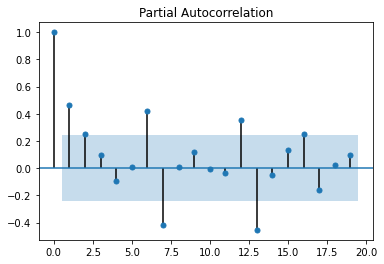

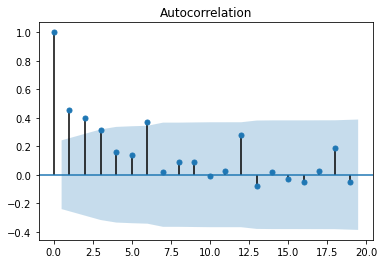

In [32]:
plot_pacf(new3);
plot_acf(new3);

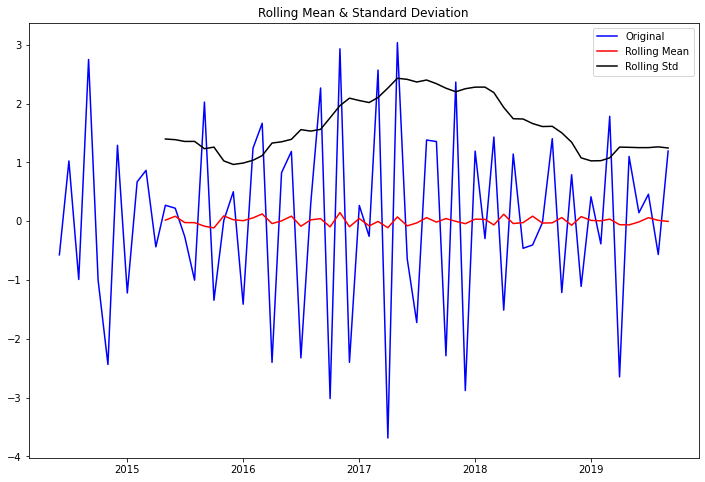

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.648931e+00
p-value                        9.963694e-07
#Lags Used                     1.000000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


In [33]:
first_diff_3 = df['Segment 2Sandesh Brand 1MobileLeopardGross Adds'].diff().diff()
first_diff_3 = first_diff_3.dropna(inplace = False)
test_stationarity(first_diff_3, window = 12)

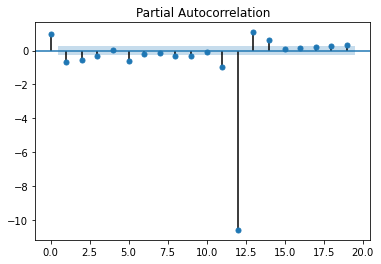

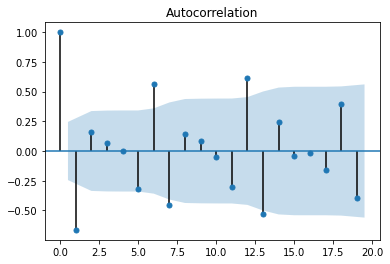

In [34]:
plot_pacf(first_diff_3);
plot_acf(first_diff_3);

In [35]:
p = range(0, 4, 1)
d = 2
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 2
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df3 = optimize_SARIMA(parameters_list, 2, 2, 4, first_diff_3)
result_df3

In [36]:
best_model3 = SARIMAX(first_diff_3, order=(2, 2, 2), seasonal_order=(2, 2, 1, 4)).fit(dis=-1)
print(best_model3.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                              SARIMAX Results                                              
Dep. Variable:     Segment 2Sandesh Brand 1MobileLeopardGross Adds   No. Observations:                   64
Model:                             SARIMAX(2, 2, 2)x(2, 2, [1], 4)   Log Likelihood                 -88.296
Date:                                             Fri, 31 Jul 2020   AIC                            192.592
Time:                                                     22:30:48   BIC                            208.504
Sample:                                                 06-01-2014   HQIC                           198.729
                                                      - 09-01-2019                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


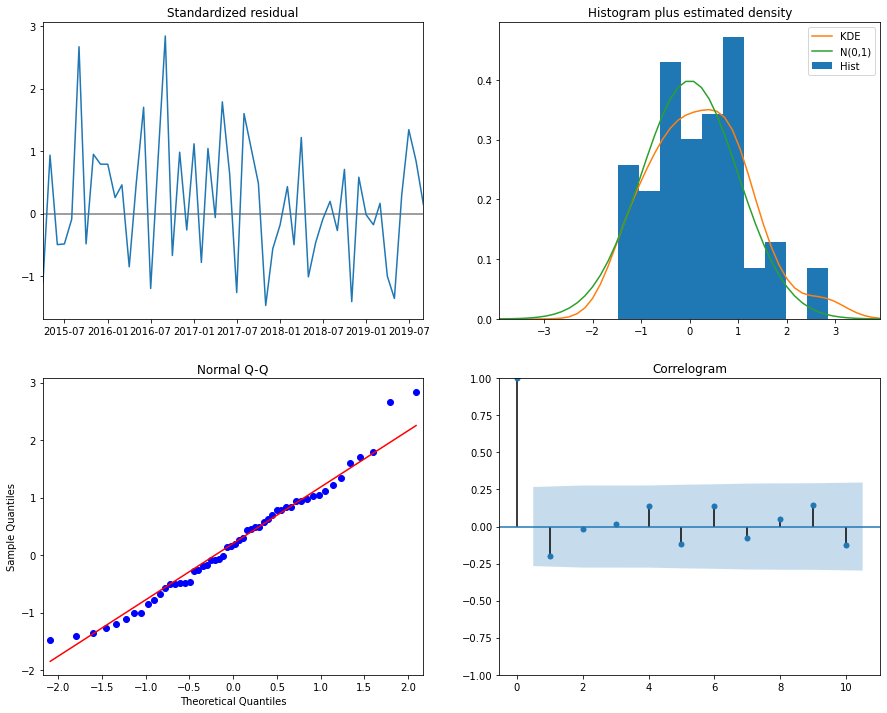

In [37]:
best_model3.plot_diagnostics(figsize=(15,12));

forecast
2020-01-01    0.625114
2020-02-01   -0.275324
2020-03-01    1.784407
2020-04-01   -2.476213
2020-05-01    1.184606
2020-06-01   -0.117921
2020-07-01    0.952296
2020-08-01   -1.121733
2020-09-01    1.136538
2020-10-01   -0.845331
2020-11-01    1.728304
2020-12-01   -2.209975
2021-01-01    0.834548
Freq: MS, dtype: float64


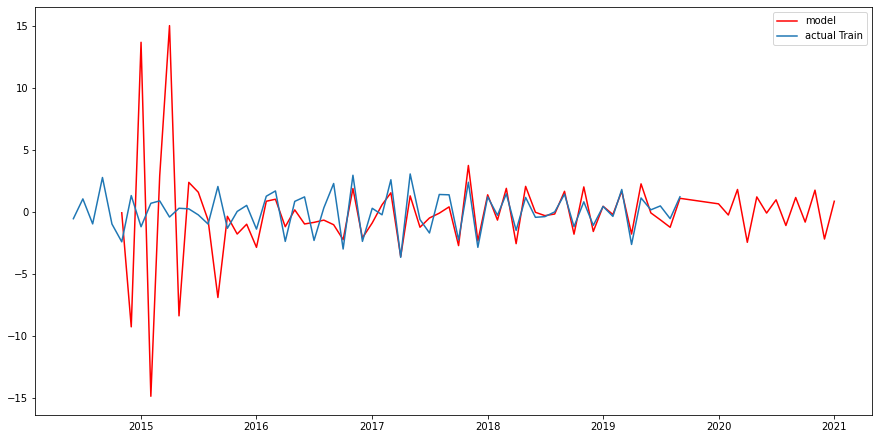

In [38]:
new3['arima_model'] = best_model3.fittedvalues
new3['arima_model'][:4+1] = np.NaN
forecast3= best_model3.predict(start=new3.shape[0], end=new3.shape[0] + 12)
x3=forecast3
print("forecast")
print(forecast3)
forecast3 = new3['arima_model'].append(forecast3)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast3, color='r', label='model')
plt.plot(first_diff_3, label='actual Train')
plt.legend()
plt.show()



In [39]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileLeopardGross Adds": x3.tolist()}))

In [40]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds
0,2019-10-01,-0.010306,0.616117,0.625114
1,2019-11-01,0.004218,-0.020009,-0.275324
2,2019-12-01,-0.022157,0.482435,1.784407
3,2020-01-01,0.182117,-1.024498,-2.476213
4,2020-02-01,-0.000945,0.867051,1.184606
5,2020-03-01,0.022556,-0.309297,-0.117921
6,2020-04-01,-0.019287,0.695308,0.952296
7,2020-05-01,0.221179,-0.714521,-1.121733
8,2020-06-01,0.012395,0.187275,1.136538
9,2020-07-01,0.044972,0.470421,-0.845331


# Column4

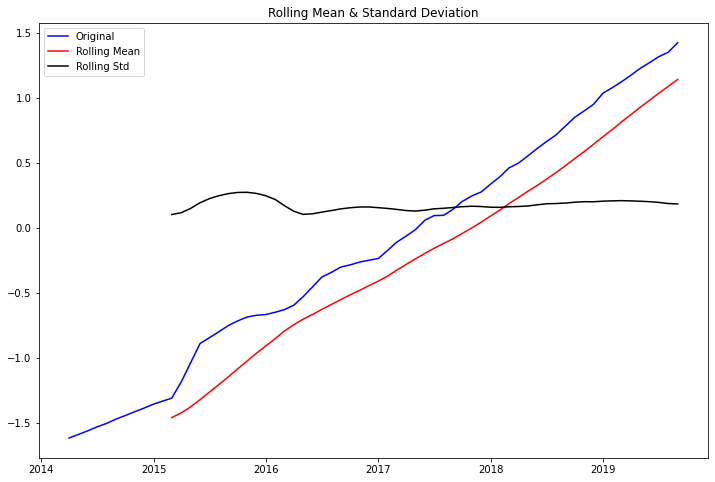

Results of Dickey-Fuller Test:
p-value = 0.9874. The series is likely non-stationary.
Test Statistic                  0.589553
p-value                         0.987355
#Lags Used                      5.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [41]:
test_stationarity(df['Segment 2Sandesh Brand 1MobilePantherClosing Base'])
new4 = df['Segment 2Sandesh Brand 1MobilePantherClosing Base']

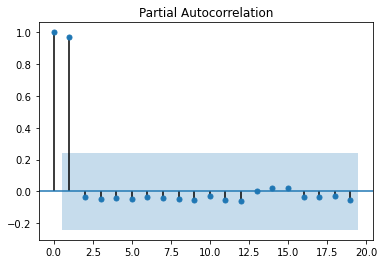

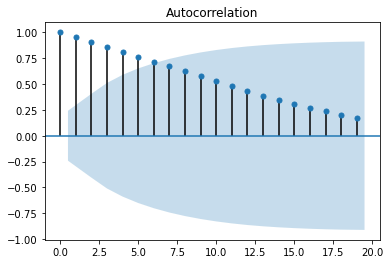

In [42]:
plot_pacf(new4);
plot_acf(new4);

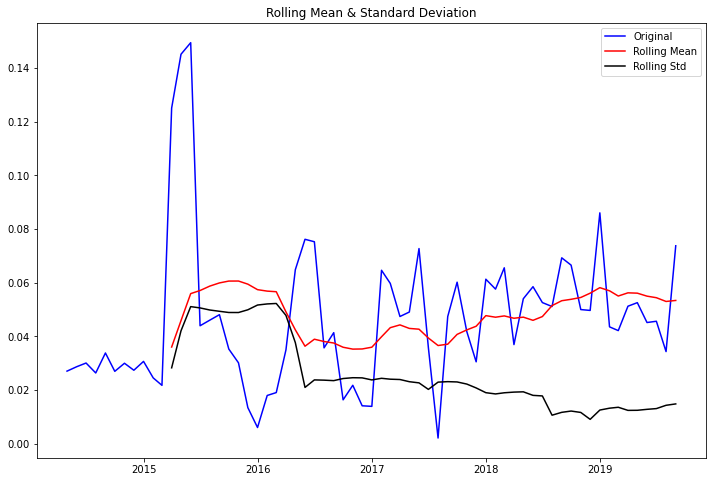

Results of Dickey-Fuller Test:
p-value = 0.0009. The series is likely stationary.
Test Statistic                 -4.129772
p-value                         0.000864
#Lags Used                      4.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [43]:
first_diff_4 = df['Segment 2Sandesh Brand 1MobilePantherClosing Base'] - df['Segment 2Sandesh Brand 1MobilePantherClosing Base'].shift(1)
first_diff_4 = first_diff_4.dropna(inplace = False)
test_stationarity(first_diff_4, window = 12)

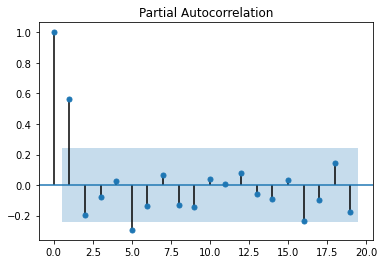

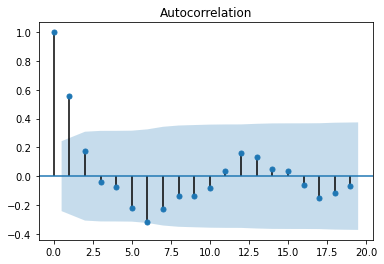

In [44]:
plot_pacf(first_diff_4);
plot_acf(first_diff_4);

In [45]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df4 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_4)
result_df4

In [46]:
best_model4 = SARIMAX(first_diff_4, order=(0, 1, 3), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model4.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                               SARIMAX Results                                               
Dep. Variable:     Segment 2Sandesh Brand 1MobilePantherClosing Base   No. Observations:                   65
Model:                               SARIMAX(0, 1, 3)x(0, 1, [1], 4)   Log Likelihood                 136.653
Date:                                               Fri, 31 Jul 2020   AIC                           -263.305
Time:                                                       22:31:12   BIC                           -252.834
Sample:                                                   05-01-2014   HQIC                          -259.209
                                                        - 09-01-2019                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

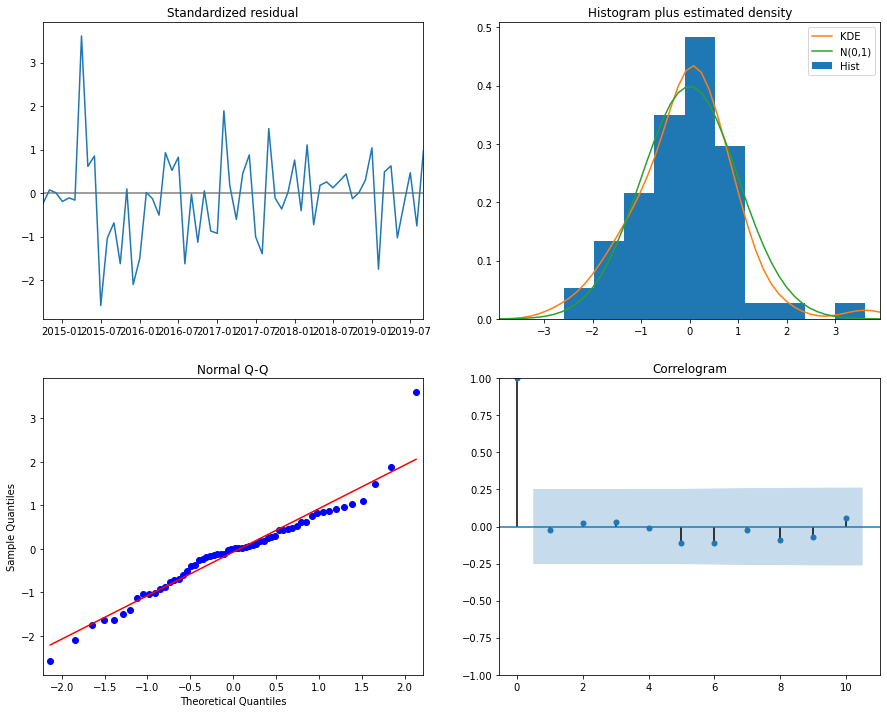

In [47]:
best_model4.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01    0.047274
2020-01-01    0.062922
2020-02-01    0.063181
2020-03-01    0.052163
2020-04-01    0.048334
2020-05-01    0.063982
2020-06-01    0.064241
2020-07-01    0.053223
2020-08-01    0.049394
2020-09-01    0.065041
2020-10-01    0.065301
2020-11-01    0.054283
2020-12-01    0.050453
Freq: MS, dtype: float64


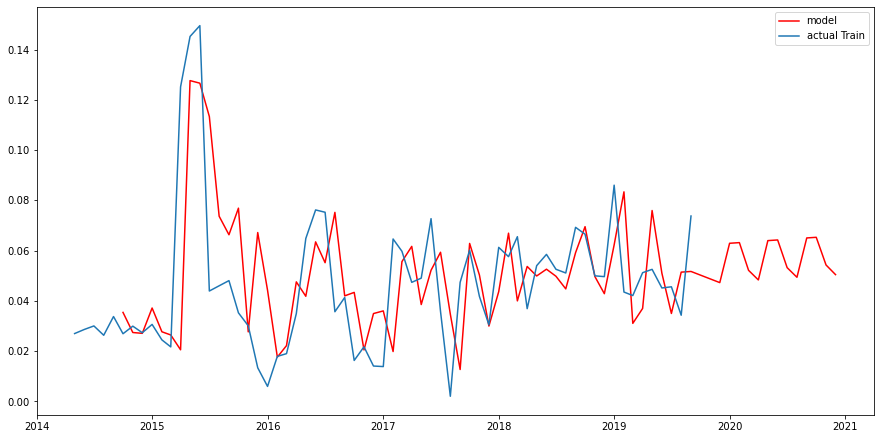

In [48]:
new4['arima_model'] = best_model4.fittedvalues
new4['arima_model'][:4+1] = np.NaN
forecast4= best_model4.predict(start=new4.shape[0], end=new4.shape[0] + 12)
x4=forecast4
print("forecast")
print(forecast4)
forecast4 = new4['arima_model'].append(forecast4)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast4, color='r', label='model')
plt.plot(first_diff_4, label='actual Train')
plt.legend()
plt.show()



In [49]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobilePantherClosing Base": x4.tolist()}))

In [50]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223
8,2020-06-01,0.012395,0.187275,1.136538,0.049394
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041


# Column 5

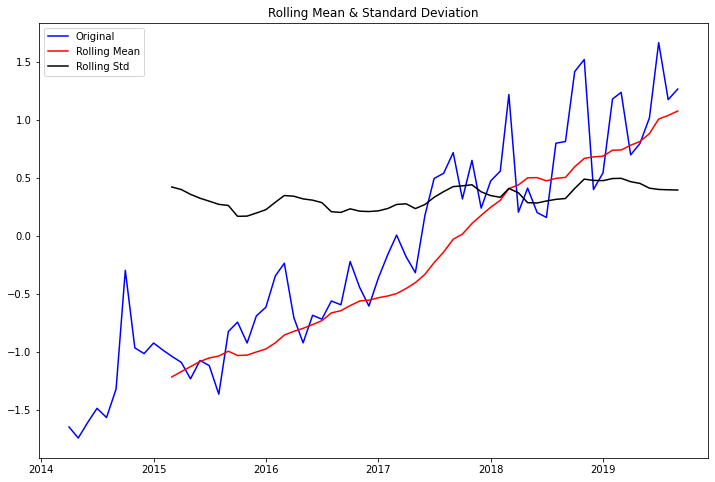

Results of Dickey-Fuller Test:
p-value = 0.9891. The series is likely non-stationary.
Test Statistic                  0.663217
p-value                         0.989074
#Lags Used                     11.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [51]:
test_stationarity(df['Segment 2Sandesh Brand 1MobilePantherLeavers'])
new5 = df['Segment 2Sandesh Brand 1MobilePantherLeavers']

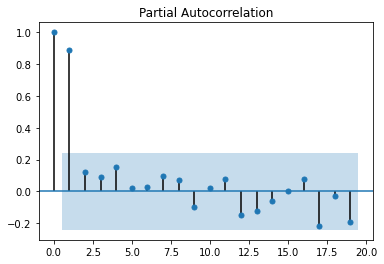

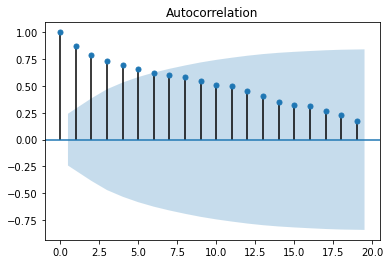

In [52]:
plot_pacf(new5);
plot_acf(new5);

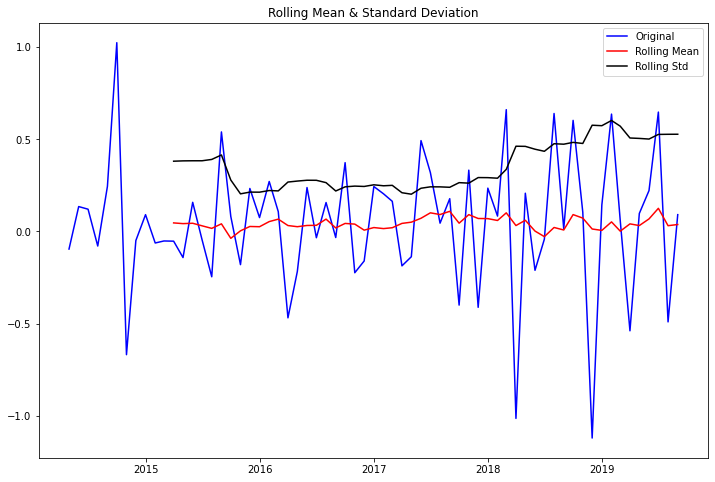

Results of Dickey-Fuller Test:
p-value = 0.0002. The series is likely stationary.
Test Statistic                 -4.473191
p-value                         0.000220
#Lags Used                      9.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [53]:
first_diff_5 = df['Segment 2Sandesh Brand 1MobilePantherLeavers'] - df['Segment 2Sandesh Brand 1MobilePantherLeavers'].shift(1)
first_diff_5 = first_diff_5.dropna(inplace = False)
test_stationarity(first_diff_5, window = 12)

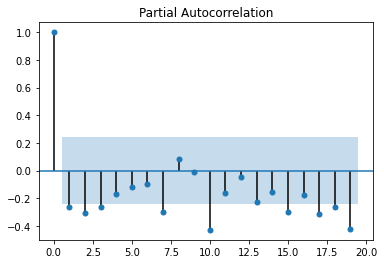

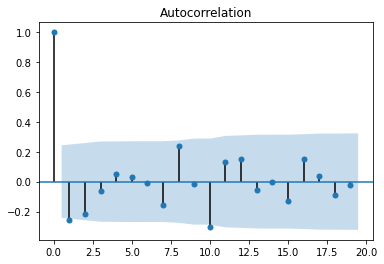

In [54]:
plot_pacf(first_diff_5);
plot_acf(first_diff_5);

In [55]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df5 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_5)
result_df5

In [56]:
best_model5 = SARIMAX(first_diff_5, order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model5.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                            SARIMAX Results                                             
Dep. Variable:     Segment 2Sandesh Brand 1MobilePantherLeavers   No. Observations:                   65
Model:                            SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                 -21.682
Date:                                          Fri, 31 Jul 2020   AIC                             53.365
Time:                                                  22:31:36   BIC                             63.836
Sample:                                              05-01-2014   HQIC                            57.461
                                                   - 09-01-2019                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma

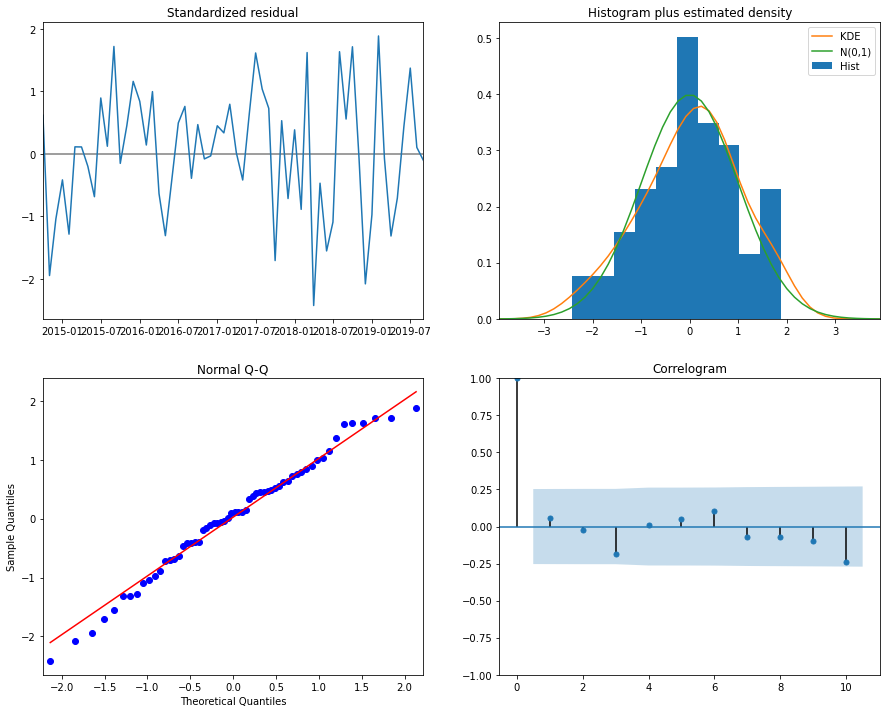

In [57]:
best_model5.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01   -0.461840
2020-01-01    0.129142
2020-02-01    0.326478
2020-03-01    0.263777
2020-04-01   -0.524476
2020-05-01    0.111111
2020-06-01    0.332300
2020-07-01    0.263910
2020-08-01   -0.524344
2020-09-01    0.111243
2020-10-01    0.332432
2020-11-01    0.264042
2020-12-01   -0.524212
Freq: MS, dtype: float64


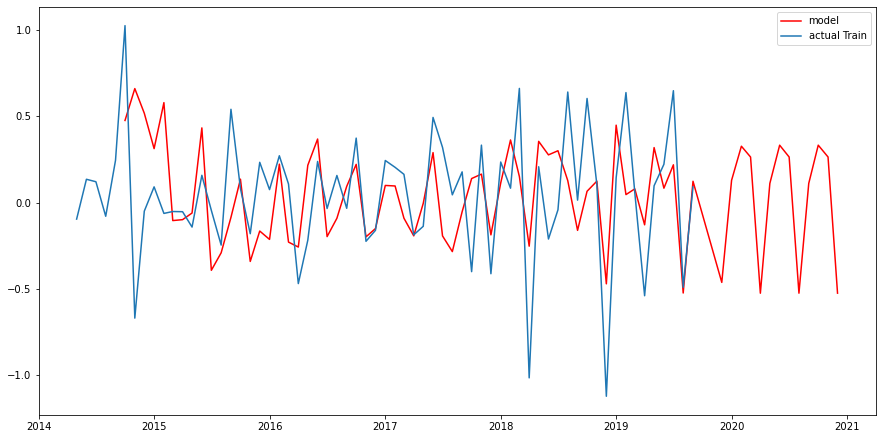

In [58]:
new5['arima_model'] = best_model5.fittedvalues
new5['arima_model'][:4+1] = np.NaN
forecast5= best_model5.predict(start=new5.shape[0], end=new5.shape[0] + 12)
x5=forecast5
print("forecast")
print(forecast5)
forecast5 = new5['arima_model'].append(forecast5)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast5, color='r', label='model')
plt.plot(first_diff_5, label='actual Train')
plt.legend()
plt.show()



In [59]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobilePantherLeavers": x5.tolist()}))

In [60]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243


# Column 6 

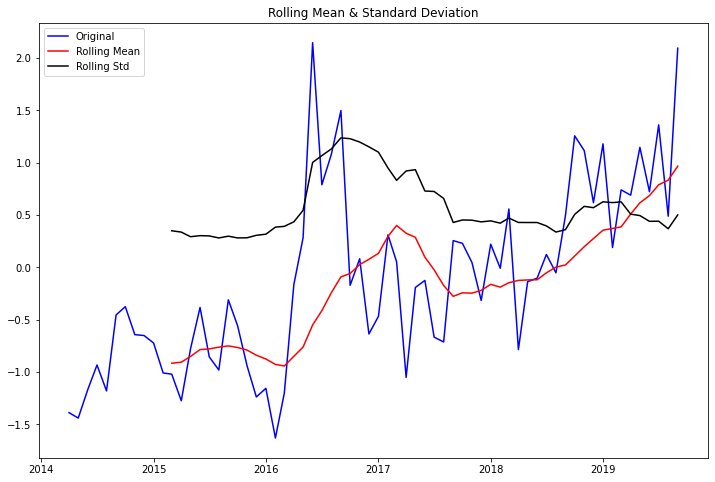

Results of Dickey-Fuller Test:
p-value = 0.2880. The series is likely non-stationary.
Test Statistic                 -1.996656
p-value                         0.288041
#Lags Used                      1.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [61]:
test_stationarity(df['Segment 2Sandesh Brand 1MobilePantherGross Adds'])
new6 = df['Segment 2Sandesh Brand 1MobilePantherGross Adds']

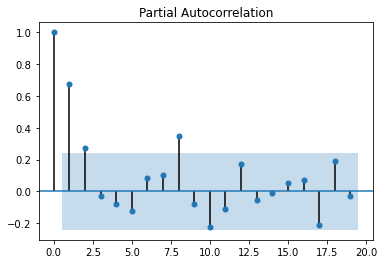

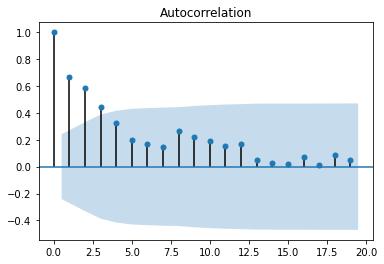

In [62]:
plot_pacf(new6);
plot_acf(new6);

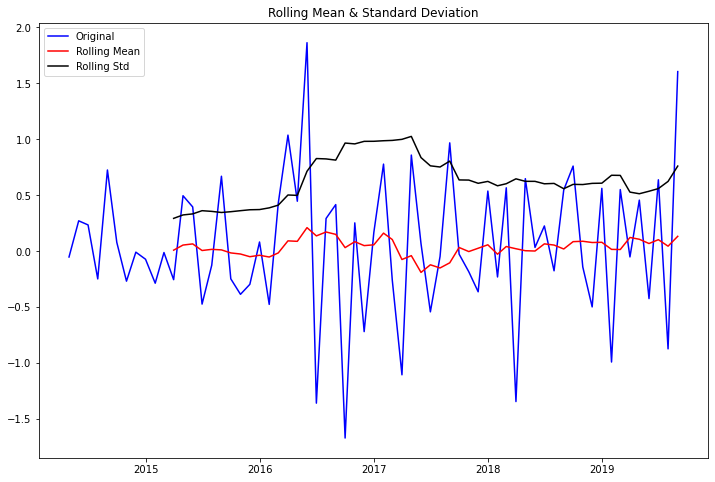

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -5.556156
p-value                         0.000002
#Lags Used                      6.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [63]:
first_diff_6 = df['Segment 2Sandesh Brand 1MobilePantherGross Adds'] - df['Segment 2Sandesh Brand 1MobilePantherGross Adds'].shift(1)
first_diff_6 = first_diff_6.dropna(inplace = False)
test_stationarity(first_diff_6, window = 12)

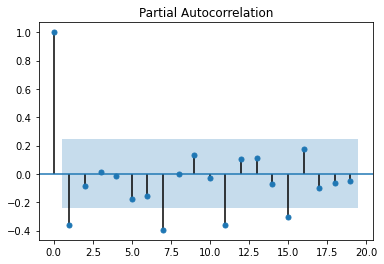

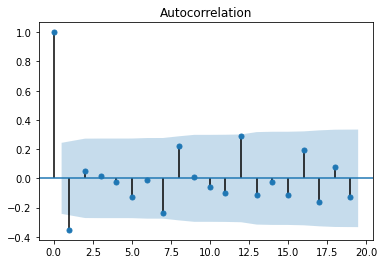

In [64]:
plot_pacf(first_diff_6);
plot_acf(first_diff_6);

In [65]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df6 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_6)
result_df6

In [66]:
best_model6 = SARIMAX(first_diff_6, order=(1, 1, 1), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model6.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                              SARIMAX Results                                              
Dep. Variable:     Segment 2Sandesh Brand 1MobilePantherGross Adds   No. Observations:                   65
Model:                          SARIMAX(1, 1, 1)x(0, 1, [1, 2], 4)   Log Likelihood                 -55.160
Date:                                             Fri, 31 Jul 2020   AIC                            120.320
Time:                                                     22:32:00   BIC                            130.792
Sample:                                                 05-01-2014   HQIC                           124.416
                                                      - 09-01-2019                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

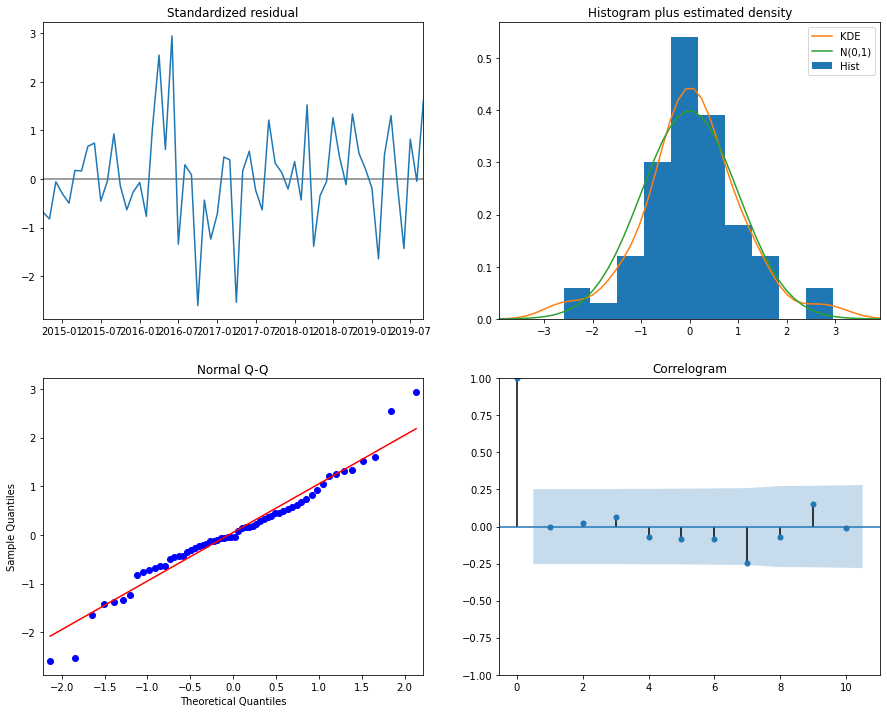

In [67]:
best_model6.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01   -0.414960
2020-01-01    0.448598
2020-02-01   -0.145203
2020-03-01    0.333059
2020-04-01   -0.471456
2020-05-01    0.803921
2020-06-01   -0.244472
2020-07-01    0.368483
2020-08-01   -0.475940
2020-09-01    0.811261
2020-10-01   -0.240635
2020-11-01    0.373358
2020-12-01   -0.471374
Freq: MS, dtype: float64


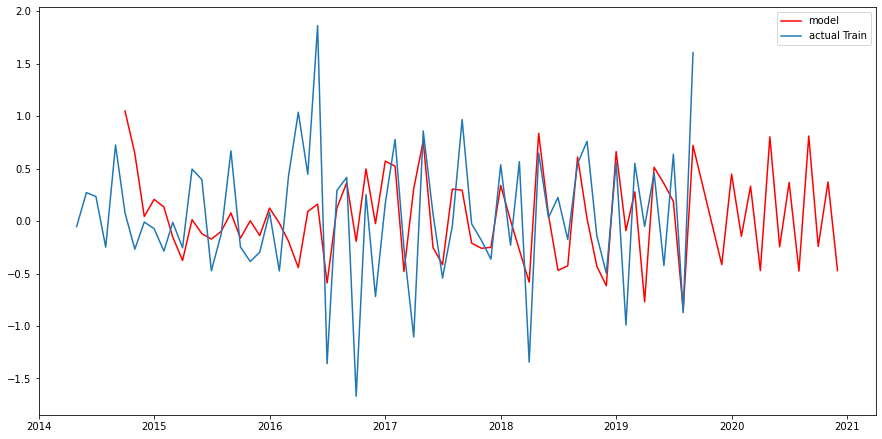

In [68]:
new6['arima_model'] = best_model6.fittedvalues
new6['arima_model'][:4+1] = np.NaN
forecast6= best_model6.predict(start=new6.shape[0], end=new6.shape[0] + 12)
x6=forecast6
print("forecast")
print(forecast6)
forecast6 = new6['arima_model'].append(forecast6)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast6, color='r', label='model')
plt.plot(first_diff_6, label='actual Train')
plt.legend()
plt.show()



In [69]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobilePantherGross Adds": x6.tolist()}))

In [70]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers,Segment 2Sandesh Brand 1MobilePantherGross Adds
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840,-0.414960
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142,0.448598
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478,-0.145203
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777,0.333059
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476,-0.471456
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111,0.803921
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300,-0.244472
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910,0.368483
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344,-0.475940
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243,0.811261


# COLUMN 7

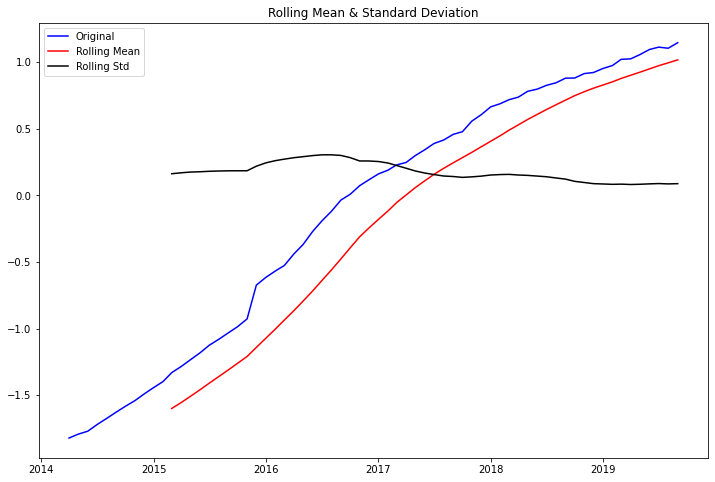

Results of Dickey-Fuller Test:
p-value = 0.0605. The series is likely non-stationary.
Test Statistic                 -2.784532
p-value                         0.060517
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [71]:
test_stationarity(df['Segment 2Sandesh Brand 1MobileHyenaClosing Base'])
new7 = df['Segment 2Sandesh Brand 1MobileHyenaClosing Base']

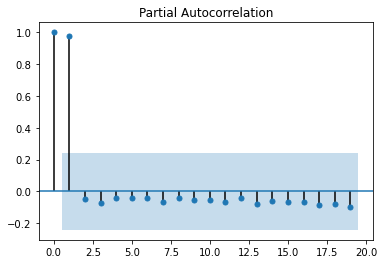

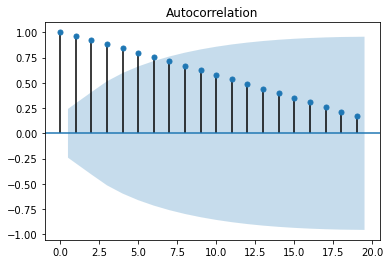

In [72]:
plot_pacf(new7);
plot_acf(new7);

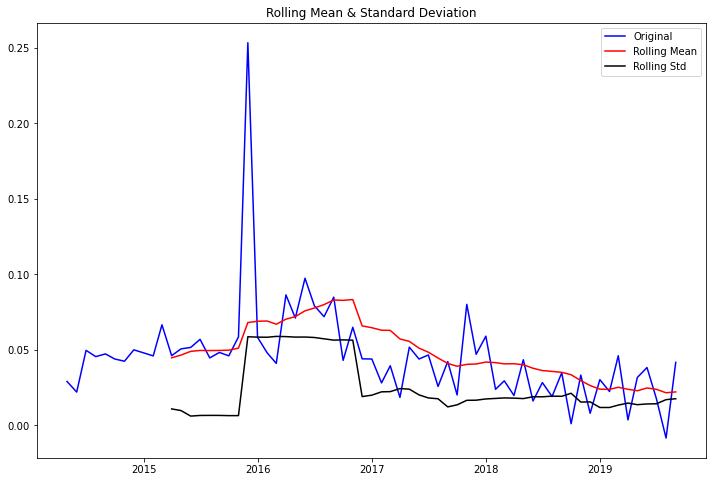

Results of Dickey-Fuller Test:
p-value = 0.0022. The series is likely stationary.
Test Statistic                 -3.883890
p-value                         0.002157
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [73]:
first_diff_7 = df['Segment 2Sandesh Brand 1MobileHyenaClosing Base'].diff()
first_diff_7 = first_diff_7.dropna(inplace = False)
test_stationarity(first_diff_7, window = 12)

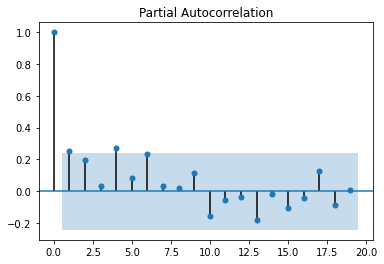

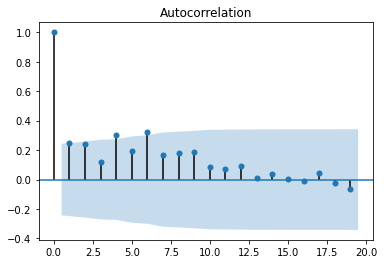

In [74]:
plot_pacf(first_diff_7);
plot_acf(first_diff_7);

In [75]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df7 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_7)
result_df7

In [76]:
best_model7 = SARIMAX(first_diff_7, order=(0, 1, 1), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model7.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                              SARIMAX Results                                              
Dep. Variable:     Segment 2Sandesh Brand 1MobileHyenaClosing Base   No. Observations:                   65
Model:                               SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 116.655
Date:                                             Fri, 31 Jul 2020   AIC                           -227.310
Time:                                                     22:32:17   BIC                           -221.027
Sample:                                                 05-01-2014   HQIC                          -224.852
                                                      - 09-01-2019                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

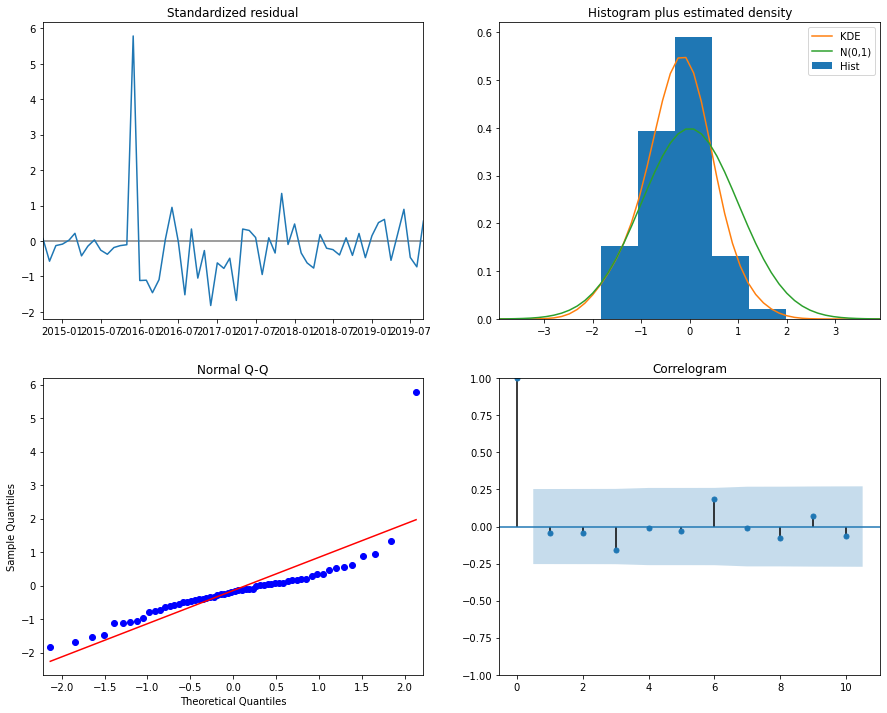

In [77]:
best_model7.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01    0.007398
2020-01-01    0.026511
2020-02-01    0.009943
2020-03-01    0.021273
2020-04-01    0.004464
2020-05-01    0.023577
2020-06-01    0.007009
2020-07-01    0.018339
2020-08-01    0.001530
2020-09-01    0.020644
2020-10-01    0.004076
2020-11-01    0.015406
2020-12-01   -0.001403
Freq: MS, dtype: float64


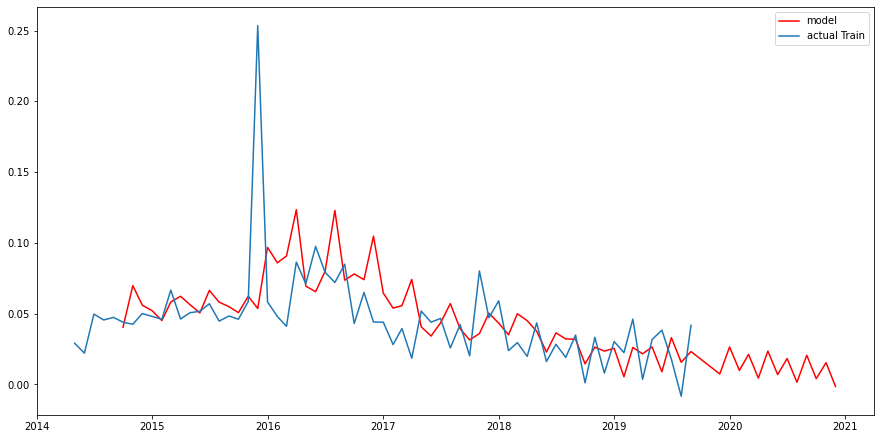

In [78]:
new7['arima_model'] = best_model7.fittedvalues
new7['arima_model'][:4+1] = np.NaN
forecast7= best_model7.predict(start=new7.shape[0], end=new7.shape[0] + 12)
x7=forecast7
print("forecast")
print(forecast7)
forecast7 = new7['arima_model'].append(forecast7)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast7, color='r', label='model')
plt.plot(first_diff_7, label='actual Train')
plt.legend()
plt.show()



In [79]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileHyenaClosing Base": x7.tolist()}))

In [80]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers,Segment 2Sandesh Brand 1MobilePantherGross Adds,Segment 2Sandesh Brand 1MobileHyenaClosing Base
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840,-0.414960,0.007398
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142,0.448598,0.026511
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478,-0.145203,0.009943
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777,0.333059,0.021273
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476,-0.471456,0.004464
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111,0.803921,0.023577
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300,-0.244472,0.007009
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910,0.368483,0.018339
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344,-0.475940,0.001530
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243,0.811261,0.020644


# COLUMN 8

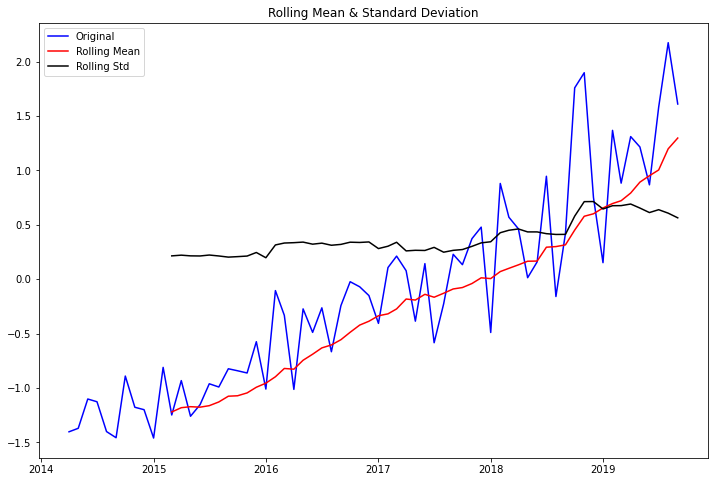

Results of Dickey-Fuller Test:
p-value = 0.9882. The series is likely non-stationary.
Test Statistic                  0.626365
p-value                         0.988248
#Lags Used                      4.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [81]:
test_stationarity(df['Segment 2Sandesh Brand 1MobileHyenaLeavers'])
new8 = df['Segment 2Sandesh Brand 1MobileHyenaLeavers']

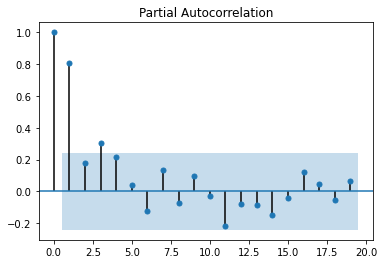

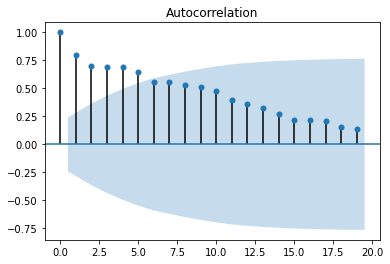

In [82]:
plot_pacf(new8);
plot_acf(new8);

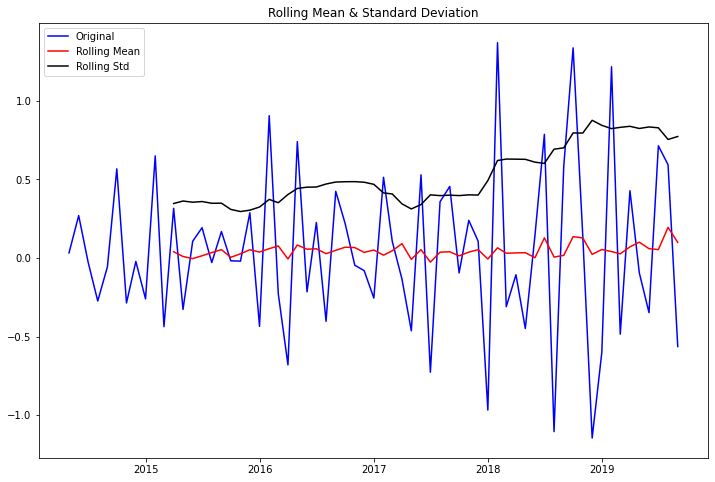

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.419805e+00
p-value                        6.783326e-11
#Lags Used                     3.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


In [83]:
first_diff_8 = df['Segment 2Sandesh Brand 1MobileHyenaLeavers'] - df['Segment 2Sandesh Brand 1MobileHyenaLeavers'].shift(1)
first_diff_8 = first_diff_8.dropna(inplace = False)
test_stationarity(first_diff_8, window = 12)

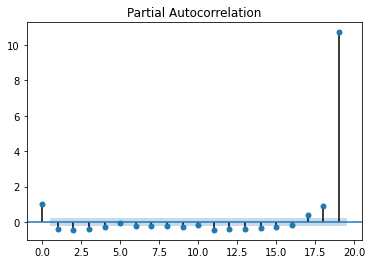

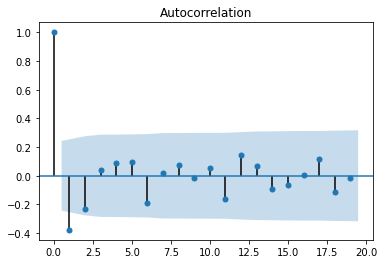

In [84]:
plot_pacf(first_diff_8);
plot_acf(first_diff_8);

In [85]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df8 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_8)
result_df8

In [86]:
best_model8 = SARIMAX(first_diff_8, order=(0, 1, 2), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model8.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                           SARIMAX Results                                            
Dep. Variable:     Segment 2Sandesh Brand 1MobileHyenaLeavers   No. Observations:                   65
Model:                        SARIMAX(0, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 -35.820
Date:                                        Fri, 31 Jul 2020   AIC                             79.640
Time:                                                22:32:33   BIC                             88.017
Sample:                                            05-01-2014   HQIC                            82.917
                                                 - 09-01-2019                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.8

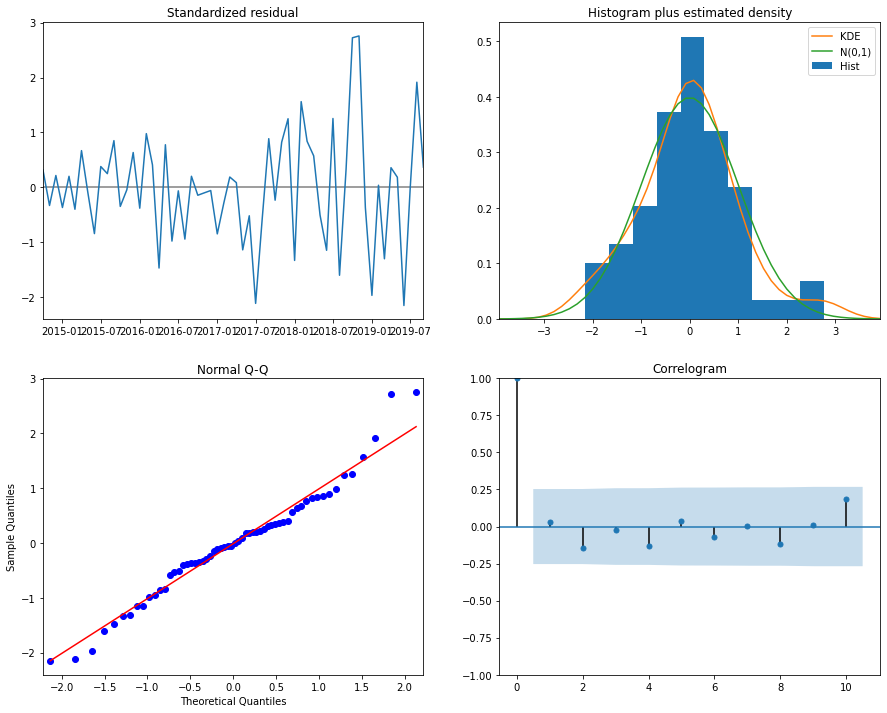

In [87]:
best_model8.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01   -0.059971
2020-01-01   -0.056478
2020-02-01    0.508546
2020-03-01    0.058971
2020-04-01   -0.052475
2020-05-01   -0.048982
2020-06-01    0.516042
2020-07-01    0.066467
2020-08-01   -0.044979
2020-09-01   -0.041486
2020-10-01    0.523538
2020-11-01    0.073963
2020-12-01   -0.037484
Freq: MS, dtype: float64


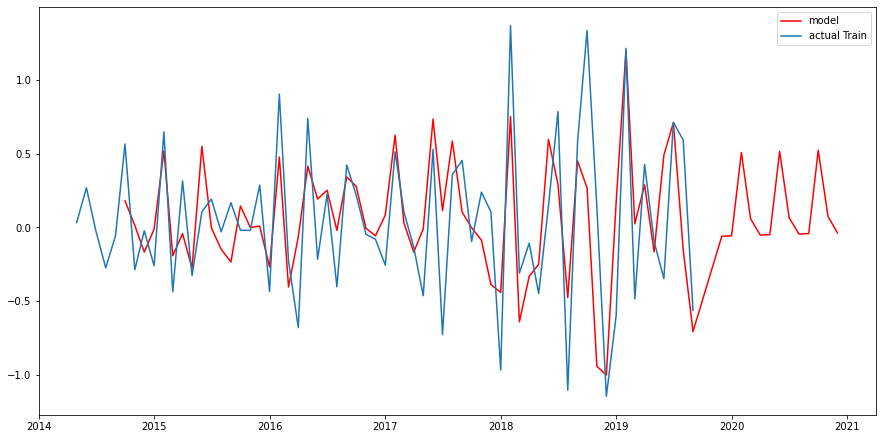

In [88]:
new8['arima_model'] = best_model8.fittedvalues
new8['arima_model'][:4+1] = np.NaN
forecast8= best_model8.predict(start=new8.shape[0], end=new8.shape[0] + 12)
x8=forecast8
print("forecast")
print(forecast8)
forecast8 = new8['arima_model'].append(forecast8)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast8, color='r', label='model')
plt.plot(first_diff_8, label='actual Train')
plt.legend()
plt.show()



In [89]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileHyenaLeavers": x8.tolist()}))

In [90]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers,Segment 2Sandesh Brand 1MobilePantherGross Adds,Segment 2Sandesh Brand 1MobileHyenaClosing Base,Segment 2Sandesh Brand 1MobileHyenaLeavers
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840,-0.414960,0.007398,-0.059971
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142,0.448598,0.026511,-0.056478
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478,-0.145203,0.009943,0.508546
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777,0.333059,0.021273,0.058971
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476,-0.471456,0.004464,-0.052475
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111,0.803921,0.023577,-0.048982
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300,-0.244472,0.007009,0.516042
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910,0.368483,0.018339,0.066467
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344,-0.475940,0.001530,-0.044979
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243,0.811261,0.020644,-0.041486


# COLUMN 9

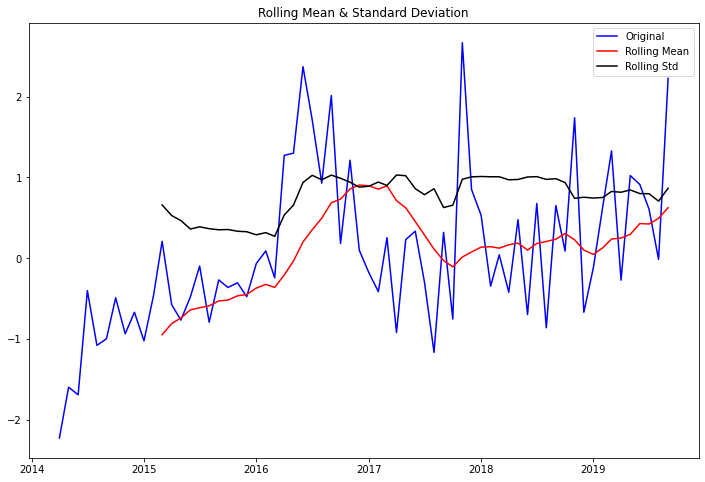

Results of Dickey-Fuller Test:
p-value = 0.0323. The series is likely non-stationary.
Test Statistic                 -3.028952
p-value                         0.032278
#Lags Used                      1.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [91]:
test_stationarity(df[ 'Segment 2Sandesh Brand 1MobileHyenaGross Adds'])
new9 = df[ 'Segment 2Sandesh Brand 1MobileHyenaGross Adds']

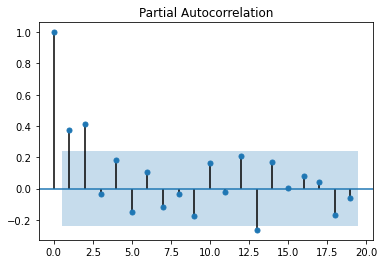

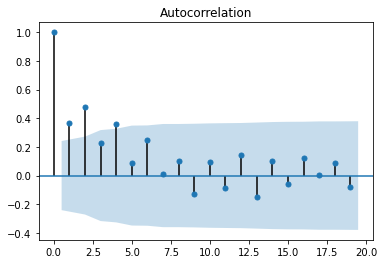

In [92]:
plot_pacf(new9);
plot_acf(new9);

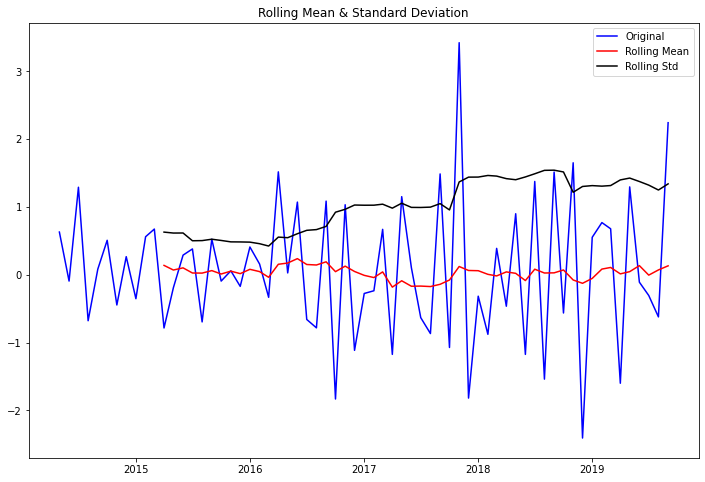

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.060574e+00
p-value                        5.236685e-10
#Lags Used                     2.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64


In [93]:
first_diff_9 = df['Segment 2Sandesh Brand 1MobileHyenaGross Adds'] - df['Segment 2Sandesh Brand 1MobileHyenaGross Adds'].shift(1)
first_diff_9 = first_diff_9.dropna(inplace = False)
test_stationarity(first_diff_9, window = 12)

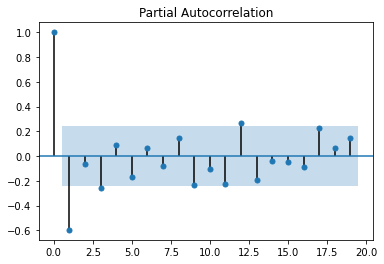

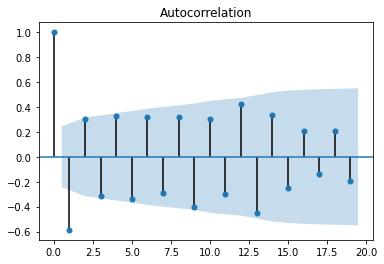

In [94]:
plot_pacf(first_diff_9);
plot_acf(first_diff_9);

In [95]:
#assigning the range of p,d,q
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
#to get the resukt of AIC and selecting the lowest AIC value
result_df9 = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_9)
result_df9

In [96]:
#model fitting
best_model9 = SARIMAX(first_diff_9, order=(0, 1, 2), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model9.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                             SARIMAX Results                                             
Dep. Variable:     Segment 2Sandesh Brand 1MobileHyenaGross Adds   No. Observations:                   65
Model:                           SARIMAX(0, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 -78.138
Date:                                           Fri, 31 Jul 2020   AIC                            164.276
Time:                                                   22:32:51   BIC                            172.653
Sample:                                               05-01-2014   HQIC                           167.553
                                                    - 09-01-2019                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

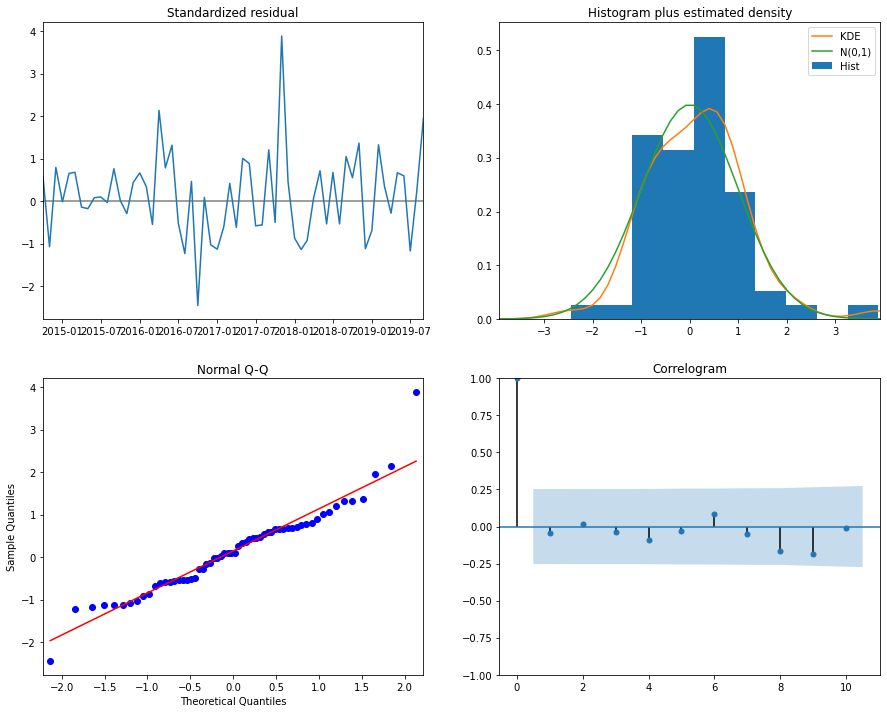

In [97]:
best_model9.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01   -1.157681
2020-01-01    1.047743
2020-02-01   -0.421445
2020-03-01    0.671074
2020-04-01   -1.160803
2020-05-01    1.044621
2020-06-01   -0.424566
2020-07-01    0.667952
2020-08-01   -1.163924
2020-09-01    1.041500
2020-10-01   -0.427688
2020-11-01    0.664831
2020-12-01   -1.167046
Freq: MS, dtype: float64


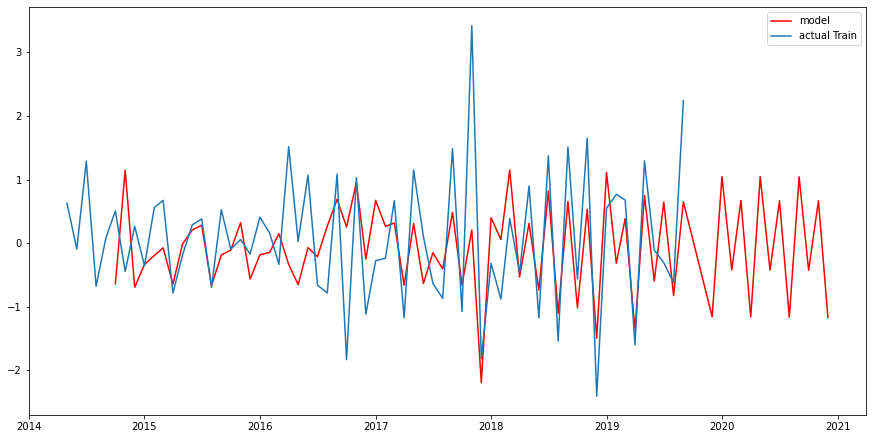

In [98]:
new9['arima_model'] = best_model9.fittedvalues
new9['arima_model'][:4+1] = np.NaN
forecast9= best_model9.predict(start=new9.shape[0], end=new9.shape[0] + 12)
x9=forecast9
print("forecast")
print(forecast9)
forecast9 = new9['arima_model'].append(forecast9)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast9, color='r', label='model')
plt.plot(first_diff_9, label='actual Train')
plt.legend()
plt.show()



In [99]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobileHyenaGross Adds": x9.tolist()}))

In [100]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers,Segment 2Sandesh Brand 1MobilePantherGross Adds,Segment 2Sandesh Brand 1MobileHyenaClosing Base,Segment 2Sandesh Brand 1MobileHyenaLeavers,Segment 2Sandesh Brand 1MobileHyenaGross Adds
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840,-0.414960,0.007398,-0.059971,-1.157681
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142,0.448598,0.026511,-0.056478,1.047743
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478,-0.145203,0.009943,0.508546,-0.421445
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777,0.333059,0.021273,0.058971,0.671074
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476,-0.471456,0.004464,-0.052475,-1.160803
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111,0.803921,0.023577,-0.048982,1.044621
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300,-0.244472,0.007009,0.516042,-0.424566
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910,0.368483,0.018339,0.066467,0.667952
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344,-0.475940,0.001530,-0.044979,-1.163924
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243,0.811261,0.020644,-0.041486,1.041500


# COLUMN 10

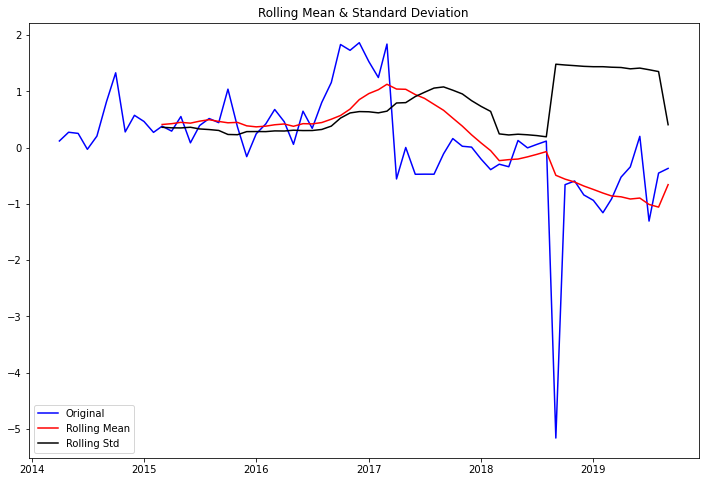

Results of Dickey-Fuller Test:
p-value = 0.0318. The series is likely non-stationary.
Test Statistic                 -3.034392
p-value                         0.031805
#Lags Used                      1.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [101]:
test_stationarity(df['Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue'])
new10 = df['Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue']

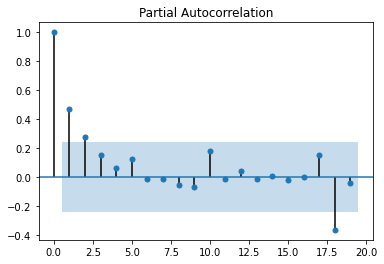

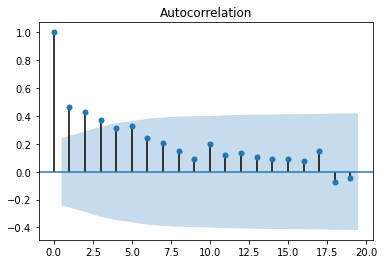

In [102]:
plot_pacf(new10);
plot_acf(new10);

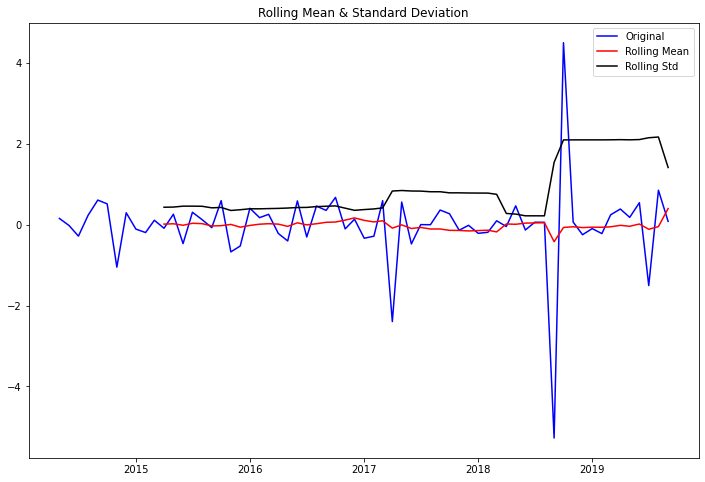

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.732296e+00
p-value                        3.167623e-14
#Lags Used                     1.000000e+00
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


In [103]:
first_diff_10 = df['Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue'] - df['Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue'].shift(1)
first_diff_10 = first_diff_10.dropna(inplace = False)
test_stationarity(first_diff_10, window = 12)


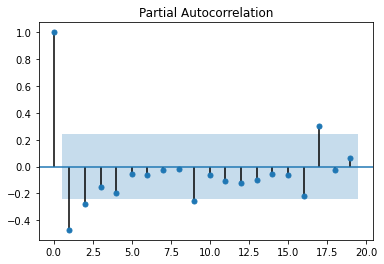

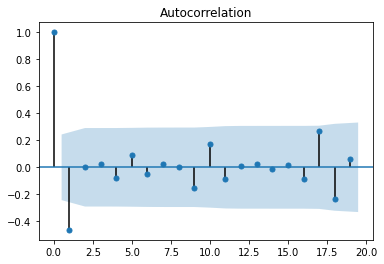

In [104]:
plot_pacf(first_diff_10);
plot_acf(first_diff_10);

In [105]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, first_diff_10)
result_df

In [107]:
best_model10 = SARIMAX(first_diff_10, order=(0, 1, 2), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model10.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                                        SARIMAX Results                                                         
Dep. Variable:     Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue   No. Observations:                   65
Model:                                                  SARIMAX(0, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 -85.439
Date:                                                                  Fri, 31 Jul 2020   AIC                            178.878
Time:                                                                          22:33:22   BIC                            187.255
Sample:                                                                      05-01-2014   HQIC                           182.155
                                                                           - 09-01-2019                                         
Covariance Type:                                                                    opg          

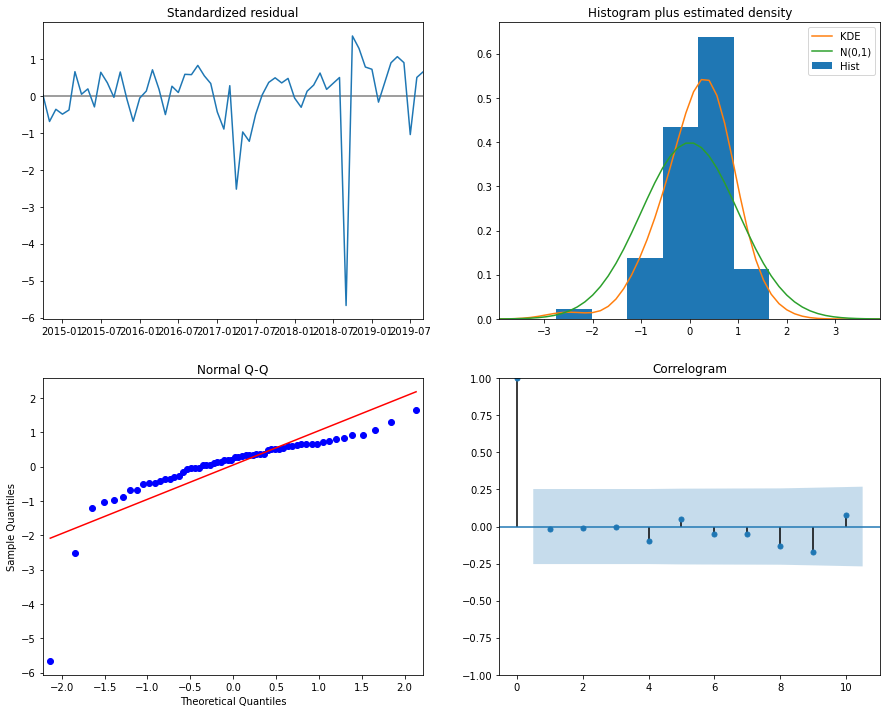

In [108]:
best_model10.plot_diagnostics(figsize=(15,12));

forecast
2019-12-01   -0.093556
2020-01-01   -0.207167
2020-02-01    0.318084
2020-03-01   -0.173004
2020-04-01   -0.096526
2020-05-01   -0.210137
2020-06-01    0.315113
2020-07-01   -0.175974
2020-08-01   -0.099497
2020-09-01   -0.213107
2020-10-01    0.312143
2020-11-01   -0.178944
2020-12-01   -0.102467
Freq: MS, dtype: float64


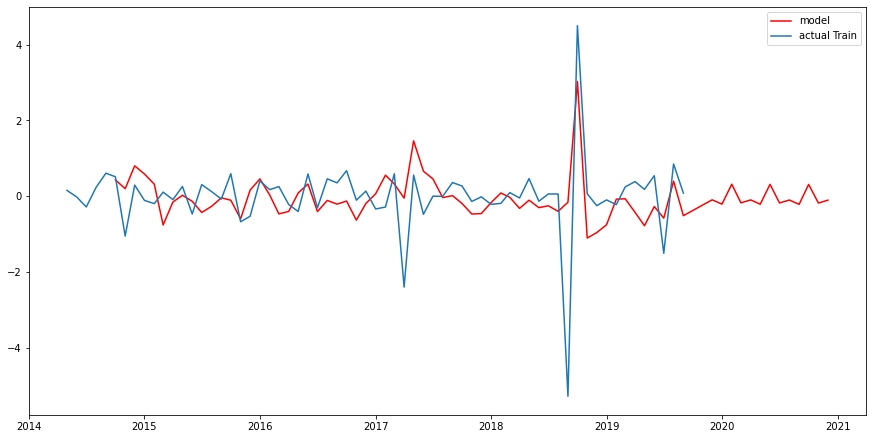

In [109]:
new10['arima_model'] = best_model10.fittedvalues
new10['arima_model'][:4+1] = np.NaN
forecast10= best_model10.predict(start=new10.shape[0], end=new10.shape[0] + 12)
x10=forecast10
print("forecast")
print(forecast10)
forecast10 = new10['arima_model'].append(forecast10)


plt.figure(figsize=(15, 7.5))
plt.plot(forecast10, color='r', label='model')
plt.plot(first_diff_10, label='actual Train')
plt.legend()
plt.show()



In [110]:
output=output.join(pd.DataFrame({"Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue": x10.tolist()}))

In [111]:
output

,Time Period,Segment 2Sandesh Brand 1MobileLeopardClosing Base,Segment 2Sandesh Brand 1MobileLeopardLeavers,Segment 2Sandesh Brand 1MobileLeopardGross Adds,Segment 2Sandesh Brand 1MobilePantherClosing Base,Segment 2Sandesh Brand 1MobilePantherLeavers,Segment 2Sandesh Brand 1MobilePantherGross Adds,Segment 2Sandesh Brand 1MobileHyenaClosing Base,Segment 2Sandesh Brand 1MobileHyenaLeavers,Segment 2Sandesh Brand 1MobileHyenaGross Adds,Segment 2Sandesh Brand 1MobilePanther - Leopard - HyenaTotal Revenue
0,2019-10-01,-0.010306,0.616117,0.625114,0.047274,-0.461840,-0.414960,0.007398,-0.059971,-1.157681,-0.093556
1,2019-11-01,0.004218,-0.020009,-0.275324,0.062922,0.129142,0.448598,0.026511,-0.056478,1.047743,-0.207167
2,2019-12-01,-0.022157,0.482435,1.784407,0.063181,0.326478,-0.145203,0.009943,0.508546,-0.421445,0.318084
3,2020-01-01,0.182117,-1.024498,-2.476213,0.052163,0.263777,0.333059,0.021273,0.058971,0.671074,-0.173004
4,2020-02-01,-0.000945,0.867051,1.184606,0.048334,-0.524476,-0.471456,0.004464,-0.052475,-1.160803,-0.096526
5,2020-03-01,0.022556,-0.309297,-0.117921,0.063982,0.111111,0.803921,0.023577,-0.048982,1.044621,-0.210137
6,2020-04-01,-0.019287,0.695308,0.952296,0.064241,0.332300,-0.244472,0.007009,0.516042,-0.424566,0.315113
7,2020-05-01,0.221179,-0.714521,-1.121733,0.053223,0.263910,0.368483,0.018339,0.066467,0.667952,-0.175974
8,2020-06-01,0.012395,0.187275,1.136538,0.049394,-0.524344,-0.475940,0.001530,-0.044979,-1.163924,-0.099497
9,2020-07-01,0.044972,0.470421,-0.845331,0.065041,0.111243,0.811261,0.020644,-0.041486,1.041500,-0.213107


In [112]:
#converting the output to .csv file for submission
output.to_csv(r'submission.csv')